In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [57]:
from collections import Counter, defaultdict
import seaborn as sns

In [58]:
# !/Users/josh/packages/cd-hit-v4.8.1-2019-0228/cd-hit-est -M 2000 -T 3 -d 0  \
#    -i ~/src/skeeters/data/long_contigs.fasta \
#    -o ~/src/skeeters/data/long_contigs_cluster

In [133]:
from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

In [134]:
def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)

In [135]:
example_row = '3	2441nt, >CMS002_026d_Rb_S149_L004~NODE_2_length_2441_cov_25.388748... at -/99.80%'
parse_cdhit_row(example_row)

Member(contig='NODE_2_length_2441_cov_25.388748', length=2441, percent_id=99.8, percent_id_sign='-', sample='CMS002_026d_Rb_S149_L004', coverage=25.388748)

In [144]:
clusters = defaultdict(list)
with open('../data/long_contigs_cluster.clstr', 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member)

In [145]:
# remove singletons
clusters = {cluster_id: clusters[cluster_id] for cluster_id in clusters if len(clusters[cluster_id]) > 1}
samples = list(set([member.sample for cluster_id in clusters for member in clusters[cluster_id]]))

In [146]:
def get_representative(cluster):
    representative = [member for member in cluster if member.percent_id_sign == '0'][0]
    return representative
def print_cluster(cluster_id):
    cluster = clusters[cluster_id]
    representative = get_representative(cluster)
    samples = defaultdict(list)
    for member in cluster:
        samples[member.sample].append(str(member.length))
    lengths_list = ','.join(['+'.join(lengths) for lengths in samples.values()])
    
    print('Cluster: ', cluster_id)
    print('Rep contig: ', representative.sample, representative.contig)
    print('Rep Length: ', representative.length)
    print('N samples: ', len(cluster))
    print('Contig Lengths: ', lengths_list)

In [147]:
print_cluster('500')

Cluster:  500
Rep contig:  CMS002_007a_Rb_S118_L004 NODE_85_length_3006_cov_5.652441
Rep Length:  3006
N samples:  4
Contig Lengths:  2523,3006,1676+1332


In [148]:
len(clusters)

2988

In [149]:
contig_to_cluster = {member.contig: cluster_id for cluster_id in clusters for member in clusters[cluster_id]}

In [150]:
def graph_from_clusters(clusters):
    G = nx.Graph()
    for cluster_id in clusters:
        for member in clusters[cluster_id]:
            if member.length > 700:
                G.add_edge(cluster_id, member.sample, attr_dict=member._asdict())
    return G

In [151]:
G = graph_from_clusters(clusters)

In [152]:
def df_from_subset(subset, aggregation = None):
    df = pd.DataFrame(columns = [cluster_id for cluster_id in clusters if cluster_id in subset], 
                      index = [sample for sample in samples if sample in subset], dtype=int).fillna(0)
    # make a heatmap
    for cluster_id in clusters:
        if cluster_id not in subset:
            continue
        for member in clusters[cluster_id]:
            if member.sample not in subset:
                continue
            if aggregation == None:
                df.loc[member.sample, cluster_id] = 1
            if aggregation == 'coverage':
                df.loc[member.sample, cluster_id] += member.coverage
            if aggregation == 'length':
                df.loc[member.sample, cluster_id] += member.length
    return df

In [153]:
def walk(nodes, G=G):
    if not isinstance(nodes, list):
        nodes = [nodes]
    return [nbr for node in nodes for nbr in G.neighbors(node) ]

In [154]:
def nbhd(start, depth=1):
    if isinstance(start, str):
        start = [start]
    n = start
    for i in range(depth):
        n = n + walk(n)
    return set(n)

In [155]:
# Test that neighborhoods grow
[len(nbhd(contig_to_cluster['NODE_2_length_2441_cov_25.388748'], i)) for i in range(4)]

[1, 14, 33, 112]

## Examples

In [74]:
def split_hannah(input):
    return [line.split('\t')[2] for line in input.split('\n')]
wuhan6 = """CMS001_042_Ra_S23	bin10	NODE_10_length_2444_cov_49.183354	1702	36384680	46.77792961 seg1=PB2
CMS001_042_Ra_S23	bin11	NODE_11_length_2437_cov_68.228814	2361	36384680	64.88994819 seg2=PB1
CMS001_042_Ra_S23	bin12	NODE_12_length_2238_cov_65.551134	2072	36384680	56.94704475 seg3=PA
CMS001_042_Ra_S23	bin13	NODE_15_length_1855_cov_99.279528	2584	36384680	71.01890136 seg4=NP
CMS001_042_Ra_S23	bin3	NODE_28_length_1501_cov_37.367978	787	36384680	21.62998273 seg5=gp
CMS001_042_Ra_S23	bin4	NODE_131_length_861_cov_90.163265	1027	36384680	28.22616552 seg6=hypoth"""

wuhan6_ish_contigs = split_hannah(wuhan6)



In [75]:
whidbey_ish = """CMS002_018b_Rb_S129_L004	bin1	NODE_4_length_2203_cov_29.747883	906	89837146	10.08491521 PA
CMS002_018b_Rb_S129_L004	bin15	NODE_10_length_884_cov_107.267658	1237	89837146	13.76935995 NP
CMS002_018b_Rb_S129_L004	bin15	NODE_9_length_939_cov_28.932715	361	89837146	4.018382329 NP
CMS002_018b_Rb_S129_L004	bin2	NODE_2_length_2430_cov_26.274968	876	89837146	9.750977619 PB1"""

whidbey_ish_contigs = split_hannah(whidbey_ish)



In [76]:
wm3_ish = """CMS001_027_Ra_S16	bin14	NODE_6_length_2203_cov_26.203669	930	29422908	31.6080246 PA
CMS001_027_Ra_S16	bin16	NODE_16_length_1779_cov_20.285546	605	29422908	20.56220955 NP
CMS001_027_Ra_S16	bin17	NODE_3_length_2447_cov_21.006751	882	29422908	29.97664269 PB1
CMS001_027_Ra_S16	bin7	NODE_4_length_2420_cov_26.034571	1026	29422908	34.87078843 PB2"""

wm3_ish_contigs = split_hannah(wm3_ish)



In [77]:
def sort_by(x_list, idx_list):
     return [x for (idx,x) in sorted(zip(idx_list,x_list), key=lambda pair: pair[0])]

In [78]:
def fish_dark_matter(bait_contigs, overlap_cutoff=0.9):
    bait_clusters = [contig_to_cluster[c] for c in bait_contigs]
    df = df_from_subset(nbhd(bait_clusters, 3))
    samples_with_bait = df.loc[:, bait_clusters].sum(axis = 1) == len(bait_clusters)
    n_samples_with_bait = df.loc[:, bait_clusters].sum().mean()
    clusters_containing_bait = df.loc[samples_with_bait].sum() >= (overlap_cutoff * n_samples_with_bait)
    clusters_not_overflowing_bait = (df.sum() * overlap_cutoff) <= n_samples_with_bait

    overlapping_clusters = df.columns[clusters_containing_bait & clusters_not_overflowing_bait]
    df = df[overlapping_clusters]
    df = df.loc[df.sum(axis = 1) > 0,:]
    
    return df

def display_dark_matter(df):
    overlapping_clusters = df.columns

    print('Found ', len(overlapping_clusters), ' candidate segments.')
    lengths = [get_representative(clusters[cluster_id]).length for cluster_id in overlapping_clusters]
    print('Segment lengths: ', sorted(lengths, reverse=True))
    for cluster in sort_by(overlapping_clusters, lengths):
        print('---')
        print_cluster(cluster)
    if (df > 0).mean().mean() < 1:
        sns.clustermap(df)

# # Add code to return a subset of the dataframe with the candidate overlapping_clusters

In [79]:
# From one wuhan 6 contig
display_dark_matter(fish_dark_matter(wuhan6_ish_contigs[:1], 0.8))

Found  6  candidate segments.
Segment lengths:  [2444, 2441, 2239, 1871, 1532, 866]
---
Cluster:  9896
Rep contig:  CMS001_038_Ra_S22 NODE_80_length_866_cov_105.239544
Rep Length:  866
N samples:  14
Contig Lengths:  857,853,861,858,861,862,851,850,861,863,852,854,862,866
---
Cluster:  3036
Rep contig:  CMS002_029e_Rb_S164_L004 NODE_27_length_1532_cov_20.452921
Rep Length:  1532
N samples:  14
Contig Lengths:  1496,1532,1501,1500,1496,1504,1497,1491,1496,1515,1491,1501,1500,1495
---
Cluster:  1807
Rep contig:  CMS002_056a_Rb_S9_L004 NODE_23_length_1871_cov_203.951505
Rep Length:  1871
N samples:  14
Contig Lengths:  1856,1868,1855,1871,1850,1860,1845,1847,1865,1865,1860,1859,1867,1858
---
Cluster:  1133
Rep contig:  CMS002_029e_Rb_S164_L004 NODE_13_length_2239_cov_35.559667
Rep Length:  2239
N samples:  14
Contig Lengths:  2222,2239,2238,2235,2221,2234,2228,2218,2228,2227,2225,2238,2228,2223
---
Cluster:  899
Rep contig:  CMS002_029c_Rb_S161_L004 NODE_9_length_2441_cov_36.508037
Rep Le

In [80]:
# wm3 candidates
display_dark_matter(fish_dark_matter(wm3_ish_contigs))

Found  6  candidate segments.
Segment lengths:  [2447, 2420, 2203, 1779, 1449, 813]
---
Cluster:  11017
Rep contig:  CMS001_046_Ra_S3 NODE_46_length_813_cov_29.523098
Rep Length:  813
N samples:  2
Contig Lengths:  813,803
---
Cluster:  3459
Rep contig:  CMS001_046_Ra_S3 NODE_15_length_1449_cov_6.100583
Rep Length:  1449
N samples:  2
Contig Lengths:  1449,1443
---
Cluster:  2065
Rep contig:  CMS001_027_Ra_S16 NODE_16_length_1779_cov_20.285546
Rep Length:  1779
N samples:  2
Contig Lengths:  1765,1779
---
Cluster:  1185
Rep contig:  CMS001_027_Ra_S16 NODE_6_length_2203_cov_26.203669
Rep Length:  2203
N samples:  2
Contig Lengths:  2196,2203
---
Cluster:  921
Rep contig:  CMS001_027_Ra_S16 NODE_4_length_2420_cov_26.034571
Rep Length:  2420
N samples:  2
Contig Lengths:  2418,2420
---
Cluster:  891
Rep contig:  CMS001_027_Ra_S16 NODE_3_length_2447_cov_21.006751
Rep Length:  2447
N samples:  2
Contig Lengths:  2447,2447


In [81]:
awuhan6_seed = 'NODE_4_length_2235_cov_10.352641'

display_dark_matter(fish_dark_matter([awuhan6_seed]))

Found  5  candidate segments.
Segment lengths:  [2449, 2442, 2245, 1534, 869]
---
Cluster:  9843
Rep contig:  CMS002_045c_Rb_S185_L004 NODE_14_length_869_cov_33.226010
Rep Length:  869
N samples:  13
Contig Lengths:  857,861,857,857,857,857,857,856,869,853,863,860,856
---
Cluster:  3027
Rep contig:  CMS002_045f_Rb_S189_L004 NODE_10_length_1534_cov_13.974605
Rep Length:  1534
N samples:  13
Contig Lengths:  1505,1534,1514,1513,1505,1476,1494,1511,1510,1507,1510,1496,1515
---
Cluster:  1122
Rep contig:  CMS002_026c_Rb_S148_L004 NODE_4_length_2245_cov_17.264299
Rep Length:  2245
N samples:  13
Contig Lengths:  2232,2230,2245,2236,2234,2185,2235,2229,2243,2239,2245,2229,2237
---
Cluster:  898
Rep contig:  CMS002_026a_Rb_S146_L004 NODE_2_length_2442_cov_5.123890
Rep Length:  2442
N samples:  13
Contig Lengths:  2434,2425,2431,2424,2436,1386,2442,2431,2416,2417,2440,2421,2435
---
Cluster:  889
Rep contig:  CMS002_045c_Rb_S185_L004 NODE_3_length_2449_cov_17.910624
Rep Length:  2449
N samples:

In [82]:
# Segment lengths
wuhan6 = [2444, 2441, 2239, 1871, 1532, 866]
wm3 = [2447, 2420, 2203, 1779, 1449, 813]
awuhan6 = [2449, 2442, 2245, 1534, 869]

likely awuhan6 is missing a segment of length around 1800.

a likely candidae appears when we broaden the search...

Found  9  candidate segments.
Segment lengths:  [6634, 2449, 2442, 2301, 2245, 2123, 1842, 1534, 869]
---
Cluster:  9843
Rep contig:  CMS002_045c_Rb_S185_L004 NODE_14_length_869_cov_33.226010
Rep Length:  869
N samples:  13
Contig Lengths:  857,861,857,857,857,857,857,856,869,853,863,860,856
---
Cluster:  3027
Rep contig:  CMS002_045f_Rb_S189_L004 NODE_10_length_1534_cov_13.974605
Rep Length:  1534
N samples:  13
Contig Lengths:  1505,1534,1514,1513,1505,1476,1494,1511,1510,1507,1510,1496,1515
---
Cluster:  1888
Rep contig:  CMS002_045e_Rb_S188_L004 NODE_7_length_1842_cov_33.126346
Rep Length:  1842
N samples:  15
Contig Lengths:  1823,1841,1815,1827,1835,1819,1838,1079,1817,1804,1839,1832,1842,1830,1838
---
Cluster:  1305
Rep contig:  CMS002_026e_Rb_S150_L004 NODE_5_length_2123_cov_21.675953
Rep Length:  2123
N samples:  15
Contig Lengths:  2085,2079,2107,2096,2093,2056,2091,1404,2087,2040,2093,2084,2089,2123,2093
---
Cluster:  1122
Rep contig:  CMS002_026c_Rb_S148_L004 NODE_4_length_

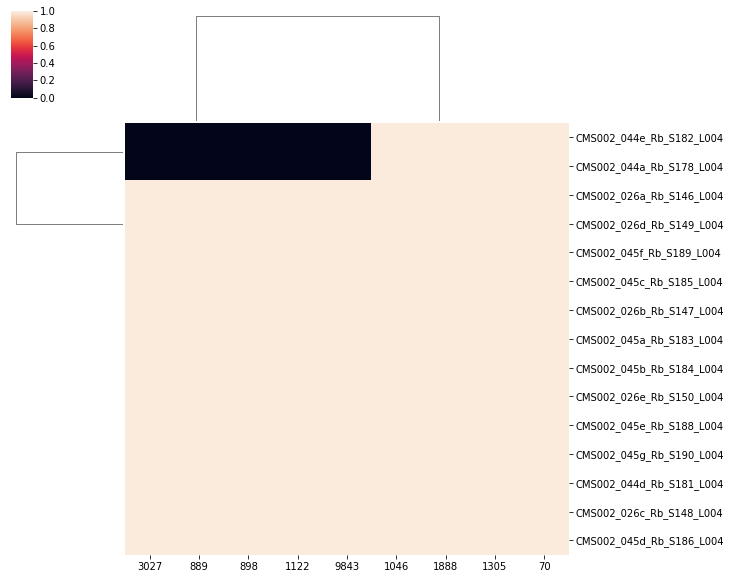

In [83]:
display_dark_matter(fish_dark_matter([awuhan6_seed], 0.8))

# Adding Species

In [156]:
metadata = pd.read_csv('../data/CMS001_CMS002_MergedAnnotations_190325.csv')
metadata.head()

,NewIDseqName,OldIDseqName,czbiohub-mosquito_sequences_id,raw_sequence_run_directory,host,sample_type,nucleotide_type,collection_date,collection_lat,collection_long,...,blood_fed,sample_unit,known_organism,detection_method,library_prep,sequencer,rna_dna_input_ng,library_prep_batch,extraction_batch,Notes:
0,CMS001_001_Ra_S1,CMS_001_RNA_A_S1,CMS_001_RNA_A_S1,czbiohub-seqbot/fastqs/180323_NB501961_0089_AH...,mosquito,whole,RNA,2017-10-03T00:00:00Z,37.55697,-122.07938,...,blood fed,1,NaN,NaN,NEBNext Ultra II Directional RNA Library Prep Kit,NextSeq,27.3,NaN,NaN,NaN
1,CMS001_002_Ra_S1,CMS_002_RNA_A_S1,CMS_002_RNA_A_S1,czbiohub-seqbot/fastqs/180412_NB501961_0097_AH...,mosquito,whole,RNA,2017-09-21T00:00:00Z,37.55697,-122.07938,...,blood fed,1,NaN,NaN,NEBNext Ultra II Directional RNA Library Prep Kit,NextSeq,59.8,NaN,NaN,NaN
2,CMS001_003_Ra_S2,CMS_003_RNA_A_S2,CMS_003_RNA_A_S2,czbiohub-seqbot/fastqs/180323_NB501961_0089_AH...,mosquito,whole,RNA,2017-09-19T00:00:00Z,37.55697,-122.07938,...,blood fed,1,NaN,NaN,NEBNext Ultra II Directional RNA Library Prep Kit,NextSeq,88.9,NaN,NaN,NaN
3,CMS001_004_Ra_S2,CMS_004_RNA_A_S2,CMS_004_RNA_A_S2,czbiohub-seqbot/fastqs/180412_NB501961_0097_AH...,mosquito,whole,RNA,2017-09-12T00:00:00Z,37.71520,-122.19431,...,blood fed,1,NaN,NaN,NEBNext Ultra II Directional RNA Library Prep Kit,NextSeq,88.4,NaN,NaN,NaN
4,CMS001_005_Ra_S3,CMS_005_RNA_A_S3,CMS_005_RNA_A_S3,czbiohub-seqbot/fastqs/180323_NB501961_0089_AH...,mosquito,whole,RNA,2017-09-29T00:00:00Z,37.78886,-122.29903,...,blood fed,1,NaN,NaN,NEBNext Ultra II Directional RNA Library Prep Kit,NextSeq,240.7,NaN,NaN,NaN


In [157]:
metadata.columns

Index(['NewIDseqName', 'OldIDseqName', 'czbiohub-mosquito_sequences_id',
       'raw_sequence_run_directory', 'host', 'sample_type', 'nucleotide_type',
       'collection_date', 'collection_lat', 'collection_long', 'Habitat',
       'Population', 'collected_by', 'preservation_method', 'sex',
       'life_stage', 'visual_genus', 'visual_species', 'compute_genus',
       'compute_species', 'blood_fed', 'sample_unit', 'known_organism',
       'detection_method', 'library_prep', 'sequencer', 'rna_dna_input_ng',
       'library_prep_batch', 'extraction_batch', 'Notes:'],
      dtype='object')

In [158]:
species = {sample: species for sample, species in zip(metadata['NewIDseqName'], metadata['compute_species'])}
genus = {sample: species for sample, species in zip(metadata['NewIDseqName'], metadata['compute_genus'])}

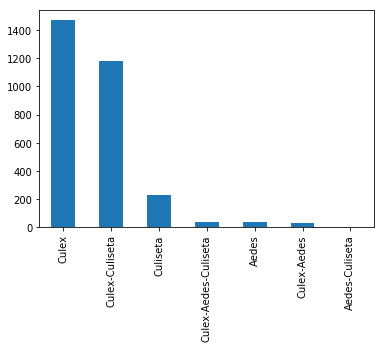

In [168]:
genus_combo = pd.Series(["-".join(set([genus[member.sample] for member in clusters[cluster_id]]))
                      for cluster_id in clusters]).value_counts()
genus_combo.plot.bar(color='C0')

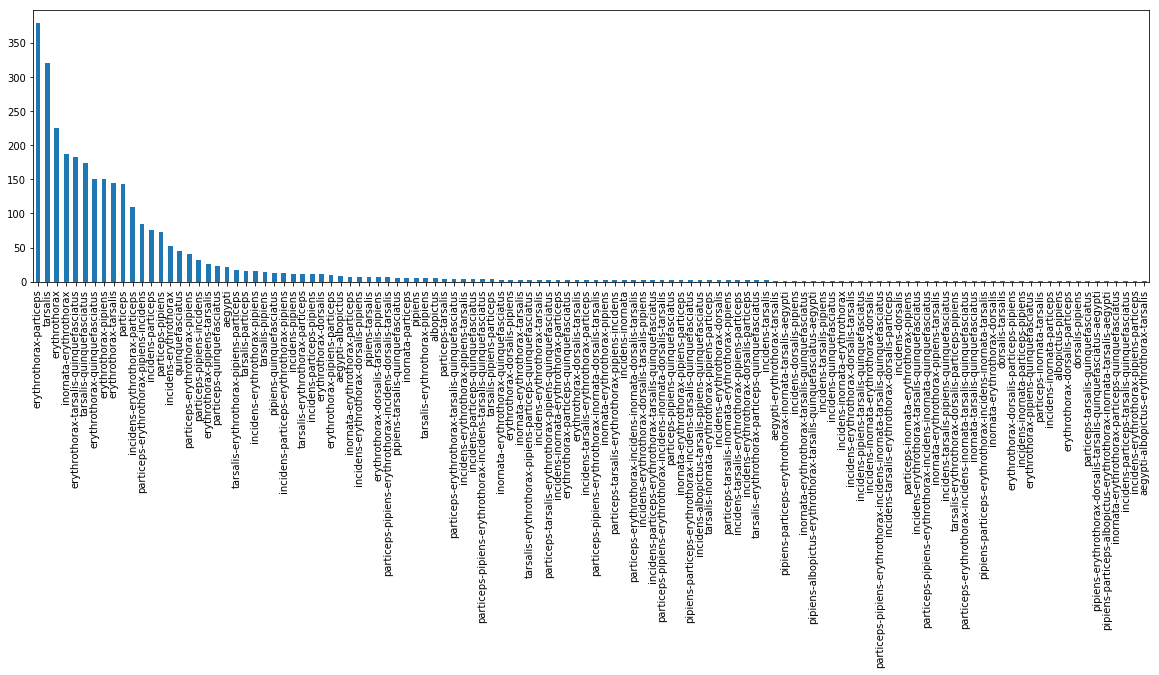

In [173]:
species_combo = pd.Series(["-".join(set([species[member.sample] for member in clusters[cluster_id]]))
                      for cluster_id in clusters]).value_counts()
species_combo.plot.bar(color='C0', figsize=(20,5))

## Graph

In [ ]:
from cyjupyter import Cytoscape
from networkx.readwrite.json_graph import cytoscape_data

In [ ]:
components = [G.subgraph(c) for c in nx.connected_components(G)]

In [ ]:
subset = nbhd(wuhan6_exemplar_clusters, 1)
subg = G.subgraph(subset)

In [ ]:
nx.draw(subg)

In [ ]:
Cytoscape(data=cytoscape_data(subg))

In [ ]:
def is_sample(node):
    return 1 if node.startswith('CMS') else 0

In [ ]:
nx.draw(subg, node_size=50, node_color = [is_sample(node) for node in subg.nodes()])

In [ ]:
Cytoscape(data=cytoscape_data(aw6_subgraph), layout_name='circle')